# Filtry Konwolucyjne

Rozwiązania (Jupyter Notebook) proszę zgłaszać przez pull request do podfolderu z imieniem i nazwiskiem.

In [14]:
import pandas as pd
import numpy as np
from numpy import zeros
import matplotlib.pyplot as plt
from imageio import imread
import math
import timeit
np.random.seed(1333)

## Funkcja Iteracyjna

In [15]:
def filter_iterative(matrix, filters, stride = [1, 1], pad=False):
  #filters is a list of filters or a singular filter
  #stride[0] = vertical, stride[1] = horizontal step
  #Filter is assumed to be of odd integer sized square
  #Matrix (image) can be of any size, at least as large as the filter
  #Both each filter and matrix need to have the same depth
  if not isinstance(filters, list): 
    filters = [filters]

  assert len(matrix.shape) == 3
  assert len(filters[0].shape) == 3
  assert filters[0].shape[2] == matrix.shape[2]
  assert matrix.shape[0] >= filters[0].shape[0] and matrix.shape[1] >= filters[0].shape[1]
  assert filters[0].shape[0] == filters[0].shape[1] and filters[0].shape[0]%2==1

  filter_rad = int(filters[0].shape[0]/2)
  if pad == True:
    matrix = np.pad(matrix, ((filter_rad,filter_rad), (filter_rad,filter_rad), (0,0)), mode='constant', constant_values=1)
  height, width, depth = matrix.shape
  stride_hor, stride_vert = (stride[1], stride[0])
  res_height = math.ceil((height-2*filter_rad)/stride_hor)
  res_width = math.ceil((width-2*filter_rad)/stride_vert)
  results = []

  for k in range(len(filters)):
    filter = filters[k]
    result = np.zeros(res_height*res_width*depth)
    result = result.reshape(res_height, res_width, depth)
    k, n = (0, 0)
    for i in range(filter_rad, height-filter_rad, stride_hor):
      for j in range(filter_rad, width-filter_rad, stride_vert):
        temp = matrix[i-filter_rad:i+filter_rad+1, j-filter_rad:j+filter_rad+1, :]
        temp = np.multiply(temp, filter)
        temp = temp.sum(axis=1).sum(axis=0)
        result[n, k, :] = temp
        k += 1
        if k == res_width:
          k = 0
          n += 1
    max = result.max()
    if max > 1 or max<0.95:
      result = result/max
    results.append(result)

  if len(results) == 1:
    return results[0]
  return results

Używanie opcji stride może być implementowane na wiele różnych sposobów (zadawałem to pytanie na zajęciach). Tutaj uznaję że gdy licząc konwolucje z filtrem wyjdziemy za macierz to zaczynamy od następnego wiersza, od pierwszego możliwego miejsca obliczenia. Inne opcje to uzywanie paddingu, zaczynanie nowego wiersza tj. "kontynuując" stride z poprzedniego, i wymyślić można jeszcze dużo więcej opcji.

## Funkcja Macierzowa

In [16]:
#Done following these two blogs:
#https://towardsdatascience.com/how-are-convolutions-actually-performed-under-the-hood-226523ce7fbf
#https://www.programmersought.com/article/37994653484/

def im2col(X, k):
    n, m = X.shape[0:2]
    mat = zeros(((n - k + 1) * (m - k + 1), k**2))
    row_num = 0

    for i in range(n- k+ 1):
        for j in range(m - k + 1):
            mat[row_num,:] = X[i:i+k, j:j+k].flatten()
            row_num = row_num + 1
    return mat

def matrix(image, filters, pad=False):
  if not isinstance(filters, list): 
    filters = [filters]
  filter_rad = int(filters[0].shape[0]/2)
  if pad == True:
    image = np.pad(image, ((filter_rad,filter_rad), (filter_rad,filter_rad), (0,0)), mode='constant', constant_values=1)
  n, m = image.shape[0:2]
  results = []

  for filter in filters:
    k = filter.shape[0]
    image_unfolded = im2col(image, k)
    filter_flat = filter.flatten()
    convoluted = np.matmul(image_unfolded, filter_flat)
    convoluted = convoluted.reshape((n-k+1, m-k+1))
    results.append(convoluted)
  return results

## Funkcje pomocnicze

In [17]:
def show_images(images, title="", original = None, greyscale=False, title_height = 0.68):
  if not isinstance(images, list): 
    images = [images]
  if original is not None:
    images = [original] + images
  fig = plt.figure(figsize=(20,16))
  length = len(images)
  for i in range(length):
    curr = images[i]
    ax = fig.add_subplot(1, length, i+1)
    if greyscale:
      curr = curr.reshape((curr.shape[0], curr.shape[1]))
      plt.imshow(curr, cmap='gray')
    else:
      plt.imshow(curr)
    if original is not None:
      if i == 0:
        ax.set_title(f'Original Image')
        continue
      ax.set_title(f'Filter no.{i}')
    else:
      ax.set_title(f'Filter no.{i+1}')
  plt.suptitle(title, y=title_height, fontsize='xx-large')
  plt.show()

In [18]:
def read_img(path):
  img = imread(path)
  if len(img.shape) == 2:
    img = img.reshape((img.shape[0], img.shape[1], 1))
  img = img/256
  return img


## Testy

In [19]:
from scipy import misc
from imageio.core import urlopen
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html
image = misc.ascent().reshape(512,512,1)
#image_cat = read_img("cat.png")
image_cat = imread(urlopen('http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/cat.png').read(), '.png')
image_cat = image_cat/256

In [20]:
filter_size = 3
depth = image.shape[2]
filter_blur = np.ones(filter_size**2*depth).reshape(filter_size,filter_size,depth)
filter_sobel = np.array([[-1, 0, 1] for i in range(3)]).reshape(3,3,1)
filter_sobel2 = np.array([[1,1,1], [0,0,0], [-1,-1,-1]]).reshape(3,3,1)
filter_random = np.random.rand(filter_size**2*depth).reshape(filter_size,filter_size,depth)
filter_gaussian = np.array([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]]).reshape(5,5,1)
filter_gaussian_rgb = np.repeat(filter_gaussian, 3, axis = 2)
filters = [filter_blur, filter_sobel2]

In [21]:
start = timeit.default_timer()
proccessed_image = filter_iterative(image, filters, stride = [1,1], pad = True)
stop = timeit.default_timer()
print(f"Runtime is {stop-start} seconds")

Runtime is 6.871479356000009 seconds


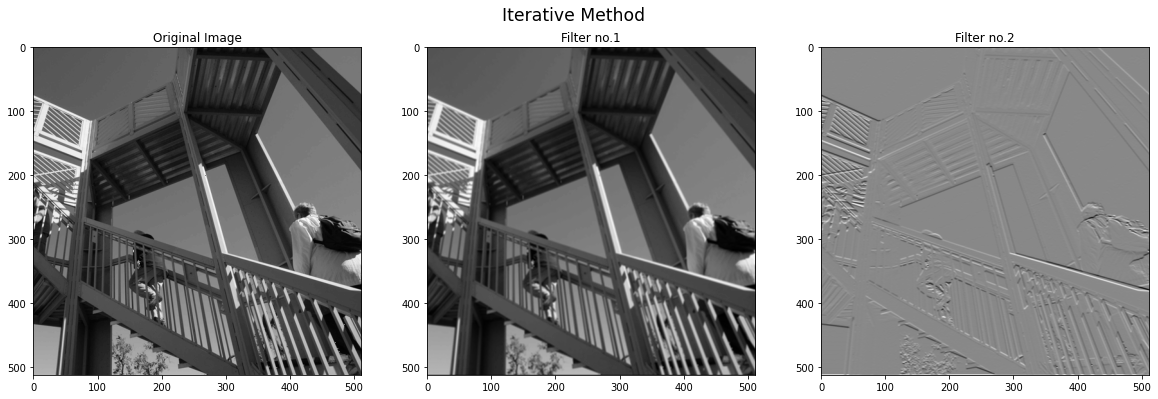

In [22]:
show_images(proccessed_image, "Iterative Method", original = image, greyscale=True)

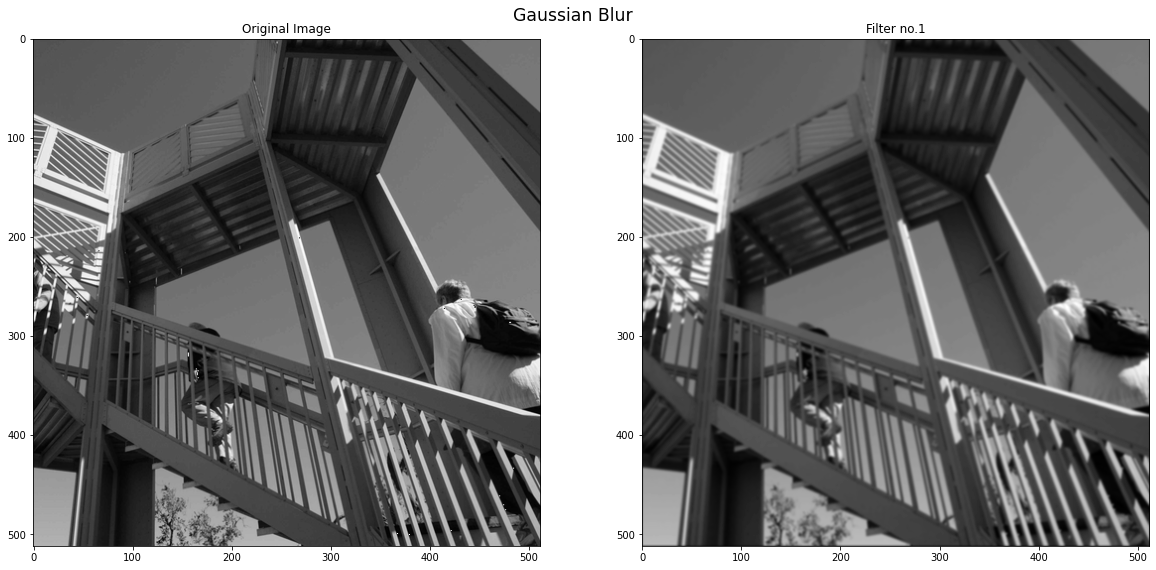

In [23]:
proccessed_image = filter_iterative(image, filter_gaussian, stride = [1,1], pad = True)
show_images(proccessed_image, "Gaussian Blur", original=image, greyscale=True, title_height=0.75)

In [24]:
start = timeit.default_timer()
tfilters = [filters[i][:,:,0] for i in range(len(filters))]
proccessed2_image = matrix(image, tfilters, pad=True)
stop = timeit.default_timer()
print(f"Runtime is {stop-start} seconds")

Runtime is 1.1937574570000038 seconds


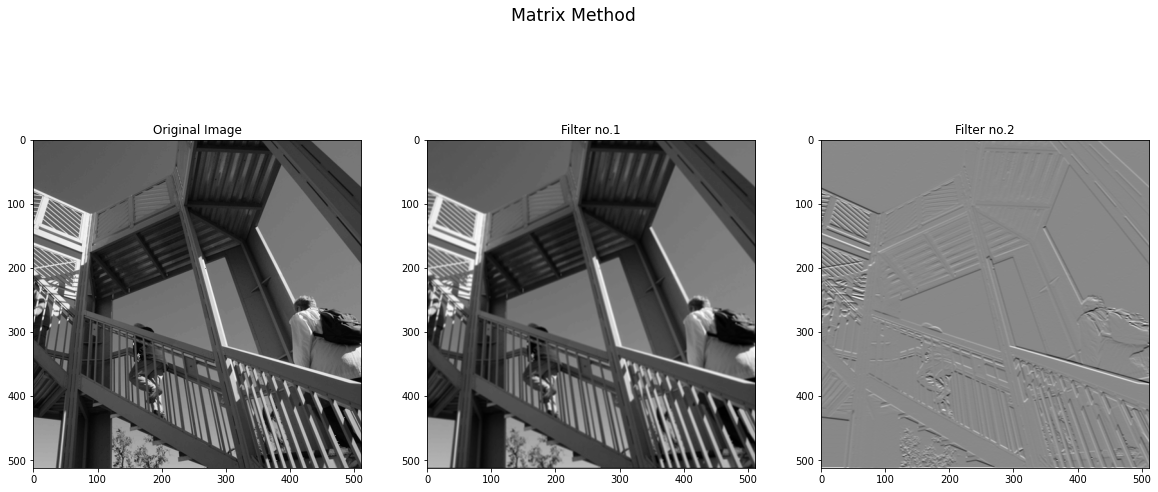

In [25]:
show_images(proccessed2_image, "Matrix Method", greyscale=True, original = image, title_height=0.76)

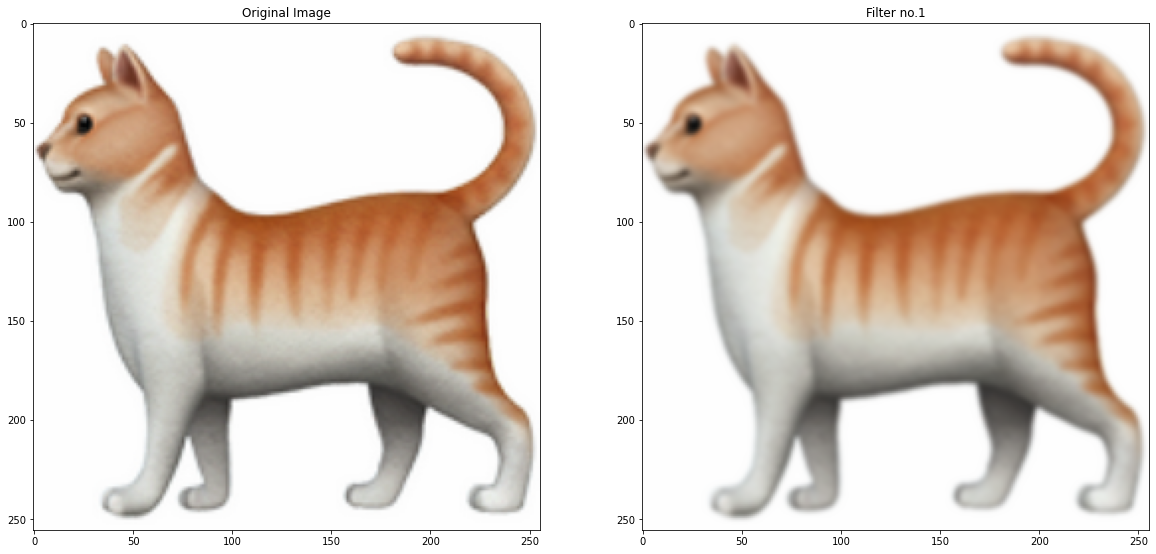

In [26]:
proccessed_image = filter_iterative(image_cat, filter_gaussian_rgb, stride = [1,1], pad = True)
show_images(proccessed_image, original=image_cat)

## Wnioski

Metoda iteracyjna na przykładzie powyższego obrazka  zabrała prawie 5s, a wersja macierzowa tylko troche ponad 1s. Tak duża przewaga zapewne jest zapewniona przez wspieranie przez komputer operacji algebraicznych (mnożenie macierzy jest częstym i bardzo dobrze zoptymalizowanym problemem, między innymi przez wielowątkowość, wektoryzacje i używanie GPU). W przypadku małych obrazów różnica ta nie jest istotna, jednak już na obrazku 512x512 z jednym kanałem, różnica jest czterokrotna. Jedynym problemem jest zrozumienie matematyczne formuły macierzowej i potrzebnych tam przekształceń. W momencie zaimplementowanej funkcji, zastosowanie filtrów takich jak rozmycie, znalezienie krawędzi, itd. jest tylko kwestią znalezienia jakie należy dać wartości w filtrze. Do Sieci Konwolucyjnych oczywiście potrzebujemy jak najszybszego wykonywania się funkcji więc zapewne stosowane są tam macierzowe operacje konwolucji.